# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.993858,1079178800,AAPL,2
1,2008-01-02,52.090000,52.320000,50.790001,40.902168,8053700,AXP,2
2,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2
3,2008-01-02,72.559998,72.669998,70.050003,48.153107,6337800,CAT,2
4,2008-01-02,27.000000,27.299999,26.209999,19.706181,64338900,CSCO,2


In [ ]:
df.shape

(98167, 8)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [ ]:
df.shape

(98167, 16)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.993858,1079178800,AAPL,2,0.0,5.999159,5.991327,100.0,-66.666667,100.0,5.993858,5.993858
3274,2008-01-02,52.090000,52.320000,50.790001,40.902168,8053700,AXP,2,0.0,5.999159,5.991327,100.0,-66.666667,100.0,40.902168,40.902168
6548,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2,0.0,5.999159,5.991327,100.0,-66.666667,100.0,63.481632,63.481632
9822,2008-01-02,72.559998,72.669998,70.050003,48.153107,6337800,CAT,2,0.0,5.999159,5.991327,100.0,-66.666667,100.0,48.153107,48.153107
13096,2008-01-02,27.000000,27.299999,26.209999,19.706181,64338900,CSCO,2,0.0,5.999159,5.991327,100.0,-66.666667,100.0,19.706181,19.706181


## Add covariance matrix as states

In [ ]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [ ]:
df.shape

(90660, 17)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2,-0.083937,3.143591,2.493910,42.254776,-80.498959,16.129793,2.793945,2.907866,"[[0.0014139107044444073, 0.0011800733448269385..."
1,2008-12-31,17.969999,18.750000,17.910000,15.064775,9625600,AXP,2,-0.966640,19.265874,13.080754,42.554841,-75.355990,25.776759,16.266707,18.201169,"[[0.0014139107044444073, 0.0011800733448269385..."
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,-0.279798,32.174390,28.867828,47.440267,156.995097,5.366299,30.327213,32.389915,"[[0.0014139107044444073, 0.0011800733448269385..."
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2,0.692236,32.043413,26.877666,51.205319,98.438755,26.331746,28.180497,27.899682,"[[0.0014139107044444073, 0.0011800733448269385..."
4,2008-12-31,16.180000,16.549999,16.120001,12.102888,37513700,CSCO,2,-0.103446,13.097644,11.486074,45.961923,11.969054,13.387087,12.060567,12.540600,"[[0.0014139107044444073, 0.0011800733448269385..."


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31

In [ ]:
train = data_split(df, '2009-01-01','2019-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [ ]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4,-0.071285,3.129850,2.491807,45.440192,-32.051658,2.140064,2.794807,2.908681,"[[0.001427708918378416, 0.0011886537599946582,..."
0,2009-01-02,18.570000,19.520000,18.400000,15.698216,10955700,AXP,4,-0.859670,19.076163,13.064186,43.957529,-42.744390,16.335101,16.265353,18.080435,"[[0.001427708918378416, 0.0011886537599946582,..."
0,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,-0.002007,32.948634,28.452123,50.822042,272.812831,20.494464,30.469478,32.344130,"[[0.001427708918378416, 0.0011886537599946582,..."
0,2009-01-02,44.910000,46.980000,44.709999,32.830360,7117200,CAT,4,0.879728,32.573560,26.855616,53.661264,129.786565,34.637448,28.430581,27.900296,"[[0.001427708918378416, 0.0011886537599946582,..."
0,2009-01-02,16.410000,17.000000,16.250000,12.592946,40980600,CSCO,4,-0.061991,13.120050,11.534206,48.322163,54.503518,2.653808,12.073190,12.517334,"[[0.001427708918378416, 0.0011886537599946582,..."


## Environment for Portfolio Allocation


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 30


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 146      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 1.91e+08 |
|    std                | 0.998    |
|    value_loss         | 2.61e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 188      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|

### Model 2: **PPO**


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 368  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:4648128.5065980535
Sharpe:  1.0442873084193252
-------------------------------------------
| time/                   |               |
|    fps                  | 336           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.1920929e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -42.6         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 8.22e+14      |
|    n_updates            | 10            |
|   

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
begin_total_asset:1000000
end_total_asset:4637501.469523684
Sharpe:  1.0373080002090542
begin_total_asset:1000000
end_total_asset:4794708.759837052
Sharpe:  1.0256592776360374
begin_total_asset:1000000
end_total_asset:4794708.759837052
Sharpe:  1.0256592776360374
begin_total_asset:1000000
end_total_asset:4794708.759837052
Sharpe:  1.0256592776360374
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 123       |
|    time_elapsed    | 81        |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -7.12e+07 |
|    critic_loss     | 4.84e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 7548      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4794708.759837052
Sharpe:  1.0256592776360374
begin_total_asset:1000000
end_total_asset:4794708.759837052
Sharpe:  1.0256592776360374
begin_total_a

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:4407825.321724843
Sharpe:  1.042031777602822
begin_total_asset:1000000
end_total_asset:4277335.402517352
Sharpe:  1.0453715342396526
begin_total_asset:1000000
end_total_asset:4277396.847191424
Sharpe:  1.0453796500001007
begin_total_asset:1000000
end_total_asset:4277495.019501329
Sharpe:  1.0453925372873427
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 68        |
|    time_elapsed    | 147       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -9.58e+07 |
|    critic_loss     | 7.93e+11  |
|    ent_coef        | 2.1       |
|    ent_coef_loss   | -140      |
|    learning_rate   | 0.0003    |
|    n_updates       | 9963      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4277522.735049063
Sharpe:  1.0453879156956518
begin_total_asset:1000000
end_tota

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

In [ ]:
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [ ]:
trade.shape

(15150, 17)

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1352313.8000969673
Sharpe:  0.6896537351975591
hit end!


In [ ]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.025461
2,2019-01-04,0.030801
3,2019-01-07,0.003712
4,2019-01-08,0.009331


In [ ]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2019-01-03,0.026667,0.023933,0.024939,0.023933,0.023933,0.032612,0.023933,0.024990,0.039123,0.062721,0.027299,0.036968,0.024877,0.023933,0.026775,0.023933,0.023933,0.023933,0.065058,0.065058,0.023933,0.023933,0.063893,0.065058,0.023933,0.023933,0.054964,0.023933,0.023933,0.023933
2019-01-04,0.025212,0.025212,0.025212,0.048861,0.025212,0.055764,0.025212,0.025212,0.033078,0.025212,0.025212,0.025212,0.042392,0.025212,0.046701,0.025212,0.057341,0.025212,0.025212,0.025212,0.038196,0.034046,0.025212,0.068534,0.025212,0.025212,0.043696,0.025212,0.050643,0.026928
2019-01-07,0.023932,0.023932,0.023932,0.065054,0.065054,0.028861,0.023932,0.052604,0.023932,0.024459,0.065054,0.026796,0.027125,0.023932,0.023932,0.023932,0.033132,0.037702,0.023932,0.023932,0.065054,0.023932,0.065054,0.028194,0.023932,0.023932,0.032949,0.023932,0.023932,0.023932
2019-01-08,0.063592,0.023394,0.023394,0.023394,0.023394,0.063592,0.023394,0.063592,0.023394,0.026228,0.035641,0.023394,0.039169,0.039997,0.023394,0.023394,0.023394,0.023394,0.032414,0.033755,0.023394,0.023394,0.052151,0.063592,0.063592,0.023394,0.023394,0.023394,0.023394,0.024986


In [ ]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.180331
Cumulative returns      0.394098
Annual volatility       0.270282
Sharpe ratio            0.748985
Calmar ratio            0.526430
Stability               0.323133
Max drawdown           -0.342554
Omega ratio             1.177482
Sortino ratio           1.068285
Skew                   -0.184792
Kurtosis               13.831125
Tail ratio              0.886888
Daily value at risk    -0.033249
Alpha                   0.000000
Beta                    1.000000
dtype: float64

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,18.033%
Cumulative returns,39.41%
Annual volatility,27.028%
Sharpe ratio,0.75
Calmar ratio,0.53
Stability,0.32
Max drawdown,-34.255%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.26,2020-02-12,2020-03-23,2020-09-02,146
1,9.00,2020-09-02,2020-10-28,2020-11-09,49
2,7.04,2019-07-23,2019-08-23,2019-10-30,72
3,6.43,2019-04-30,2019-05-31,2019-06-18,36
4,3.75,2020-01-17,2020-01-31,2020-02-12,19


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


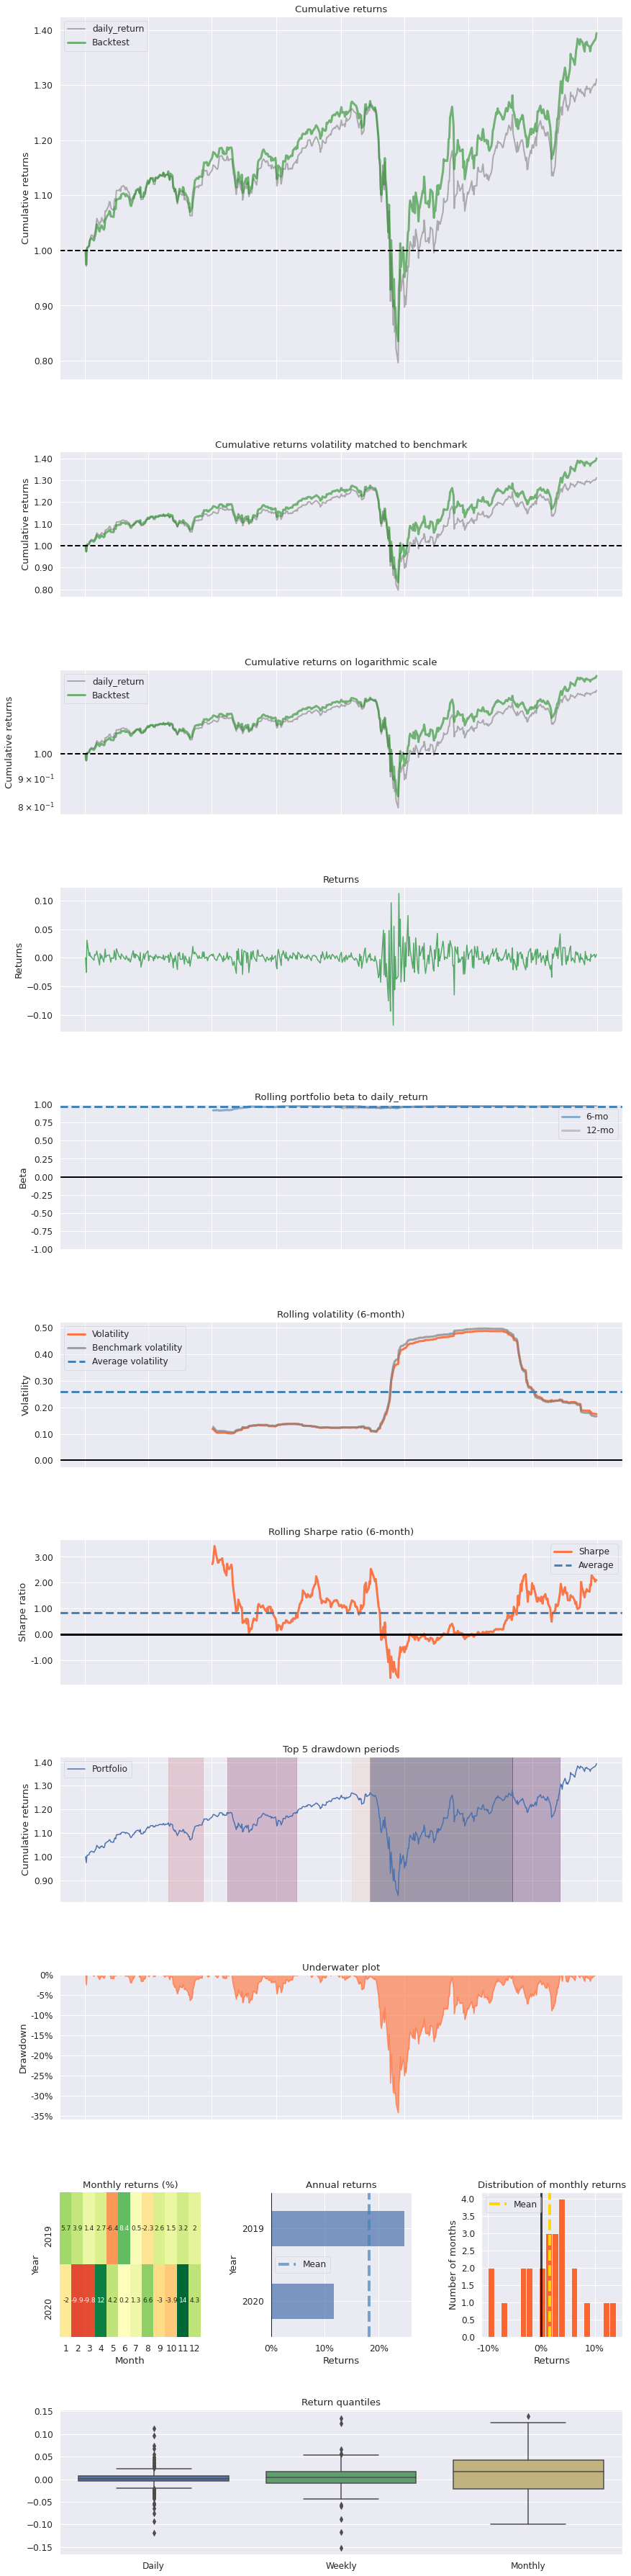

In [ ]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [ ]:
# Save models
save_path = './' + config.TRAINED_MODEL_DIR
trained_a2c.save(save_path+'/trained_a2c.zip')
trained_ppo.save(save_path+'/trained_ppo.zip')
trained_ddpg.save(save_path+'/trained_ddpg.zip')
trained_sac.save(save_path+'/trained_sac.zip')

In [ ]:
from pyfolio import timeseries
import pyfolio
%matplotlib inline

def evaluate_model(trained_model, mod_name):
    trade = data_split(df,'2019-01-01', '2021-01-01')
    e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

    df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_model,
                            environment = e_trade_gym)
    df_daily_return.index = df_daily_return['date']
    # df_actions.index = df_actions['date']
    # df_daily_return.to_csv(config.RESULTS_DIR+f'/daily_returns_{mod_name}.csv')
    # df_actions.to_csv(config.RESULTS_DIR+f'/actions_{mod_name}.csv')
    return df_daily_return, df_actions
    # DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
    # perf_func = timeseries.perf_stats 
    # perf_stats_all = perf_func( returns=DRL_strat, 
    #                             factor_returns=DRL_strat, 
    #                                 positions=None, transactions=None, turnover_denom="AGB")
    
    # baseline_df = get_baseline(
    #         ticker='^DJI', start='2019-01-01', end='2021-01-01'
    #     )

    # baseline_returns = get_daily_return(baseline_df, value_col_name="close")

    # with pyfolio.plotting.plotting_context(font_scale=1.1):
    #         pyfolio.create_full_tear_sheet(returns = DRL_strat,
    #                                     benchmark_rets=baseline_returns, set_context=False)

In [ ]:
returns_a2c, actions_a2c = evaluate_model(trained_a2c, 'a2c')
returns_ddpg, actions_ddpg = evaluate_model(trained_ddpg, 'ddpg')
returns_ppo, actions_ppo = evaluate_model(trained_ppo, 'ppo')
returns_sac, actions_sac = evaluate_model(trained_sac, 'sac')

begin_total_asset:1000000
end_total_asset:1308541.1450753717
Sharpe:  0.6308911109849498
hit end!
begin_total_asset:1000000
end_total_asset:1421727.1502687503
Sharpe:  0.7716039269747378
hit end!
begin_total_asset:1000000
end_total_asset:1392787.2697406206
Sharpe:  0.747740078086061
hit end!
begin_total_asset:1000000
end_total_asset:1389475.8740022355
Sharpe:  0.7678024076771498
hit end!


In [ ]:
port_value_a2c = returns_a2c['daily_return'].add(1).fillna(1).cumprod()*1000000
port_value_ddpg = returns_ddpg['daily_return'].add(1).fillna(1).cumprod()*1000000
port_value_ppo = returns_ppo['daily_return'].add(1).fillna(1).cumprod()*1000000
port_value_sac = returns_sac['daily_return'].add(1).fillna(1).cumprod()*1000000

# Compare to DJI portfolio
baseline_returns[0] = 0
# baseline_returns = pd.DataFrame(data=baseline_returns, index=returns_a2c.index)
port_value_baseline = baseline_returns.add(1).fillna(1).cumprod()*1000000

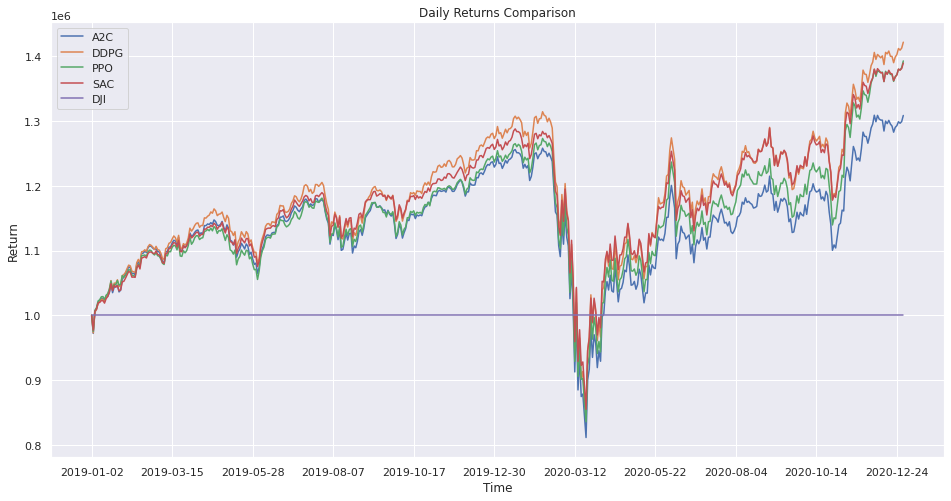

In [ ]:
import seaborn as sns
sns.set_theme(style='darkgrid')
plt.figure(figsize=(16,8))
plt.plot(port_value_a2c, label='A2C')
plt.plot(port_value_ddpg, label='DDPG')
plt.plot(port_value_ppo, label='PPO')
plt.plot(port_value_sac, label='SAC')
plt.plot(port_value_baseline, label='DJI')
plt.xticks(ticks=port_value_a2c.index[::50])
plt.title('Daily Returns Comparison')
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()
plt.savefig(config.RESULTS_DIR+'/returns_plot.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
port_value_baseline

pandas.core.frame.DataFrame

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start='2019-01-01', end='2021-01-01'
    )
baseline_returns_2 = get_daily_return(baseline_df, value_col_name="close")


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


In [ ]:
baseline_returns_2.add(1).fillna(1).cumprod()*1000000

date
2019-01-02 00:00:00+00:00    1.000000e+06
2019-01-03 00:00:00+00:00    9.717291e+05
2019-01-04 00:00:00+00:00    1.003723e+06
2019-01-07 00:00:00+00:00    1.007929e+06
2019-01-08 00:00:00+00:00    1.018899e+06
                                 ...     
2020-12-24 00:00:00+00:00    1.293565e+06
2020-12-28 00:00:00+00:00    1.302307e+06
2020-12-29 00:00:00+00:00    1.299381e+06
2020-12-30 00:00:00+00:00    1.302546e+06
2020-12-31 00:00:00+00:00    1.310981e+06
Name: daily_return, Length: 505, dtype: float64

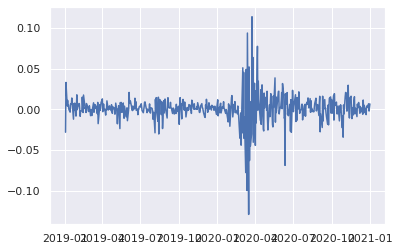

In [ ]:
plt.plot(baseline_returns_2)

In [ ]:
!pip install pyportfolioopt

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 1.3MB 15.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2731621 sha256=9dcc29cae7287d7e494b0b692ea73a1da76ec56b5a1cd645e299a83a4a3d1ca5
  Stored in directory: /root/.cache/pip/wheels/9b/62/55/1da181c05c710c5d99bd560edebec3bd6a61cb69acef9dc00e
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
dow30_df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

djia_df = get_baseline(
        ticker='DJIA', start='2008-01-01', end='2021-01-01'
    )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
dow30_df = dow30_df.pivot(index = 'date',columns = 'tic', values = 'close')
dow30_df.head()

tic,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-02,5.993858,40.902168,63.481632,48.153107,19.706181,56.150730,36.441830,27.012505,172.133408,18.570772,70.470428,16.988043,44.369019,30.197594,20.215322,39.262402,57.438839,35.318649,26.256372,13.296494,12.730652,48.174393,34.439720,37.761494,47.682396,NaN,21.031298,27.543497,34.476433,59.068382
2008-01-03,5.996627,40.397320,63.745468,47.982674,19.862106,56.841633,36.234943,26.953121,169.844910,18.364504,70.611824,16.532345,44.382481,29.989922,20.427099,39.147514,57.431862,35.287868,26.368216,13.176723,12.880682,48.174393,34.929695,38.266319,47.901161,NaN,21.128649,25.861679,34.094181,59.270527
2008-01-04,5.538875,39.379547,62.895321,46.721413,19.394316,56.084610,34.786674,26.410151,165.773712,17.752827,68.074089,15.192071,44.321888,29.309633,20.466816,38.552841,56.779083,34.998516,25.630169,12.972904,12.686200,47.981190,34.352722,37.061932,47.118656,NaN,20.734402,25.293699,33.609009,58.165096
2008-01-07,5.464737,39.555847,60.733349,46.857765,19.401747,55.351646,34.965355,26.435602,161.462112,18.044443,67.347076,15.332792,45.008526,29.603231,20.949944,39.215107,56.327671,35.657249,25.801632,13.050653,12.908470,48.294315,34.192444,37.530708,47.859085,NaN,21.099445,25.869057,34.226501,57.621826
2008-01-08,5.268161,38.425911,58.564034,45.780571,18.882000,54.642719,34.683228,25.909611,157.125610,17.596355,65.691162,14.917308,45.062397,28.428841,21.035980,38.573116,55.702663,36.728443,24.936844,12.991817,13.041832,48.420906,32.873669,36.384026,47.295345,NaN,20.642263,25.249437,33.792797,56.882763


In [ ]:
djia_df = djia_df.pivot(index = 'date',columns = 'tic', values = 'close')
djia_df.head()

In [ ]:
dow30_df.head()

In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(dow30_df)
S = risk_models.sample_cov(dow30_df)

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1268: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


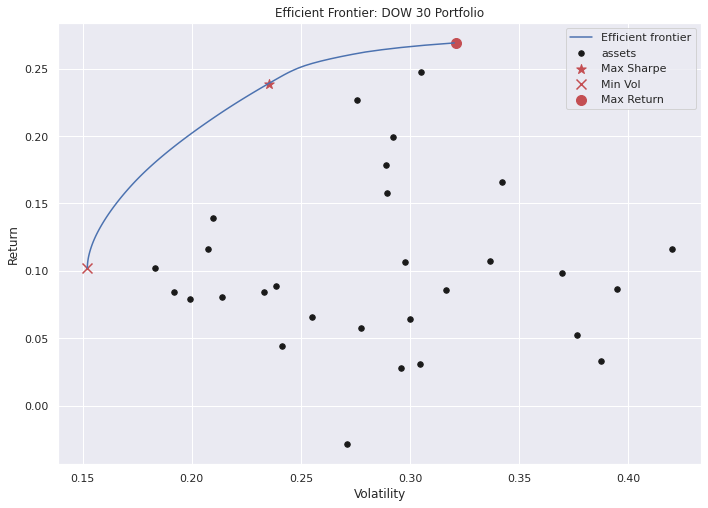

In [ ]:
ef = EfficientFrontier(mu, S)
plt.figure(figsize=(10,7))
ax = plot_efficient_frontier(ef)
# Find the tangency portfolio
weights = ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef = EfficientFrontier(mu, S)
ef.min_volatility()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="x", s=100, c="r", label="Min Vol")

ef = EfficientFrontier(mu, S)
ef.efficient_risk(0.6)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r", label='Max Return')
plt.title('Efficient Frontier: DOW 30 Portfolio')
ax.legend()
# plt.savefig(config.RESULTS_DIR+'/eff_frontier_plot.png')

In [ ]:
dow30_rets = dow30_df.pct_change()
portfolio_weights_ew = np.repeat(1/30, 30)
returns_1n = dow30_rets.mul(portfolio_weights_ew, axis=1).sum(axis=1)

In [ ]:
returns_1n

date
2008-01-02    0.000000
2008-01-03   -0.002435
2008-01-04   -0.022323
2008-01-07    0.004301
2008-01-08   -0.016769
                ...   
2020-12-24    0.002267
2020-12-28    0.005899
2020-12-29   -0.001170
2020-12-30    0.002215
2020-12-31    0.006155
Length: 3274, dtype: float64

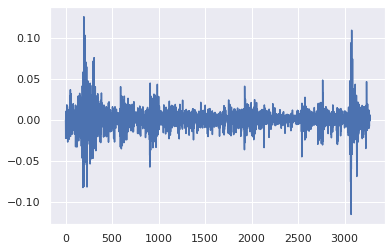

In [ ]:
plt.plot(returns_1n.values)

In [ ]:
djia_df.pct_change()

tic,DJIA
date,
2008-01-02,NaN
2008-01-03,0.000978
2008-01-04,-0.019648
2008-01-07,0.002134
2008-01-08,-0.018587
...,...
2020-12-24,0.002325
2020-12-28,0.006758
2020-12-29,-0.002246


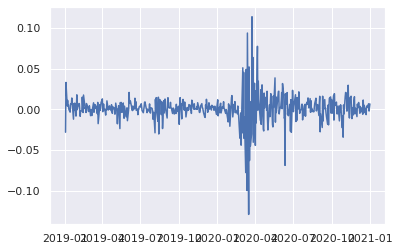

In [ ]:
plt.plot(baseline_returns_2)

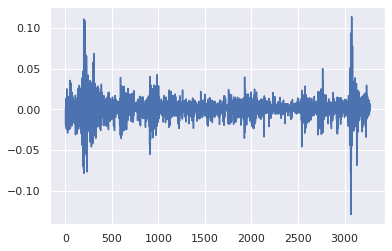

In [ ]:
plt.plot(djia_df.pct_change().values)